In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import cv2
from glob import glob
import seaborn as sns
sns.set()

import sklearn
import skimage
from skimage.transform import resize

import random
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

In [1]:
train = "./dataset/train"

test = "./dataset/test"



LOAD_FROM_IMAGES = False

def get_data(folder):
    x = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith("."):
            if folderName in ["nofire"]:
                label = 0
            elif folderName in ["fire"]:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder +"/" +folderName+"/")):
                img_file = cv2.imread(folder + "/" +folderName + "/" + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file,(128,128,3), mode = "constant",anti_aliasing=True)
                    #img_file = rgb2gray(img_file)
                    img_arr = np.asarray(img_file)
                    x.append(img_arr)
                    y.append(label)
    x = np.asarray(x)
    y = np.asarray(y)
    return x,y

if LOAD_FROM_IMAGES:
    X_train,y_train = get_data(train)
    X_test, y_test = get_data(test)
    
    np.save("xtrain.npy",X_train)
    np.save("ytrain.npy",y_train)
    np.save("xtest.npy",X_test)
    np.save("ytest.npy",y_test)
else:
    X_train = np.load("xtrain.npy")
    y_train = np.load("ytrain.npy")
    X_test = np.load("xtest.npy")
    y_test = np.load("ytest.npy")

NameError: name 'np' is not defined

In [3]:
X_train.shape

(1832, 128, 128, 3)

In [4]:
future_extractor = models.Sequential()

future_extractor.add(layers.Conv2D(64,(3,3),activation="relu",input_shape=(128,128,3)))
future_extractor.add(layers.MaxPooling2D((2,2)))
future_extractor.add(BatchNormalization())
future_extractor.add(Dropout(0.5))

future_extractor.add(layers.Conv2D(64,(3,3),activation="relu"))
future_extractor.add(layers.MaxPooling2D((2,2)))

future_extractor.add(layers.Conv2D(64,(3,3),activation="relu"))
future_extractor.add(layers.MaxPooling2D((2,2)))

future_extractor.add(layers.Flatten())


In [5]:
x = future_extractor.output
x = (layers.Dense(128,activation="relu"))(x)
x = (BatchNormalization())(x)
x = (Dropout(0.5))(x)
pred_layer = (layers.Dense(2,activation="softmax"))(x)

In [6]:
from keras.models import Model
cnn_model = Model(inputs=future_extractor.input, outputs=pred_layer)

In [7]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928 

In [8]:
cnn_model.compile(optimizer = "adam" , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [9]:
batch_size=8
epochs=50

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

custom_early_stopping = EarlyStopping(monitor='accuracy', patience=20,restore_best_weights=True),ModelCheckpoint(filepath=os.path.join(os.path.join("checkpoint"), 'model.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5'))

In [11]:
history =  cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data =(X_test,y_test),callbacks=[custom_early_stopping])

Epoch 1/50
229/229 [==============================] - 69s 281ms/step - loss: 0.3003 - accuracy: 0.8854 - val_loss: 1.0747 - val_accuracy: 0.3382
Epoch 2/50
229/229 [==============================] - 73s 319ms/step - loss: 0.2333 - accuracy: 0.9121 - val_loss: 1.5059 - val_accuracy: 0.3235
Epoch 3/50
229/229 [==============================] - 69s 302ms/step - loss: 0.2353 - accuracy: 0.9159 - val_loss: 1.0507 - val_accuracy: 0.5441
Epoch 4/50
229/229 [==============================] - 66s 290ms/step - loss: 0.2535 - accuracy: 0.9165 - val_loss: 0.4697 - val_accuracy: 0.7794
Epoch 5/50
229/229 [==============================] - 65s 285ms/step - loss: 0.2520 - accuracy: 0.9165 - val_loss: 0.6331 - val_accuracy: 0.7353
Epoch 6/50
229/229 [==============================] - 65s 285ms/step - loss: 0.2231 - accuracy: 0.9187 - val_loss: 0.2628 - val_accuracy: 0.9265
Epoch 7/50
229/229 [==============================] - 65s 285ms/step - loss: 0.2187 - accuracy: 0.9192 - val_loss: 0.5303 - val_ac

In [12]:
score = cnn_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

9/9 [==============================] - 1s 57ms/step - loss: 0.0990 - accuracy: 0.9559
Test loss: 0.09904195368289948
Test accuracy: 0.9558823704719543


In [13]:
y_test_pred = cnn_model.predict(X_test)

In [14]:
y_pred = (y_test_pred > 0.5)
y_pred=np.argmax(y_pred, axis=1)

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

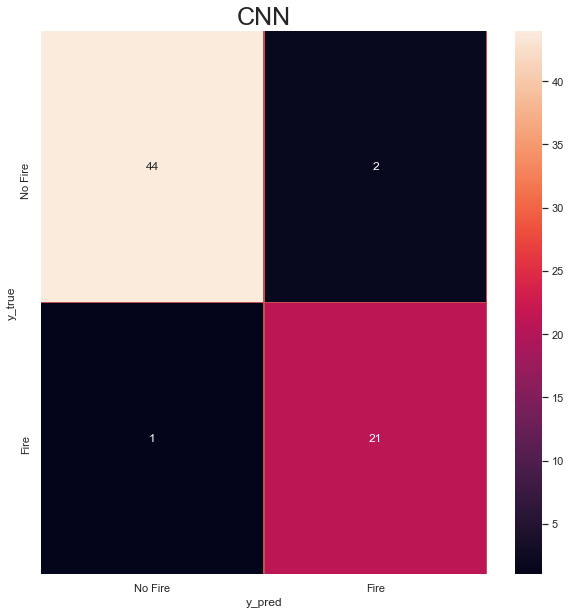

In [16]:
def confusion(y_test,y_test_pred,X):
    names=['No Fire','Fire']
    cm=confusion_matrix(y_test,y_test_pred)
    f,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.title(X, size = 25)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.savefig('confusion_matrix_cnn.jpg')
    plt.show()

    return
confusion(y_test,y_pred,"CNN")

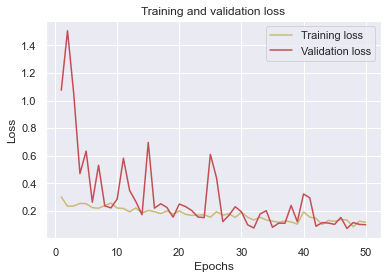

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.jpg')
plt.show()

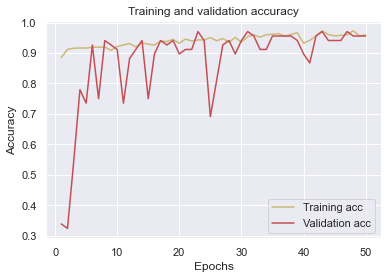

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.jpg')
plt.show()

In [20]:
from keras.models import model_from_json
json_file = open('future_extractor.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
future_extractor = model_from_json(loaded_model_json)
# load weights into new model
future_extractor.load_weights("future_extractor.h5")
print("Loaded model from disk")

Loaded model from disk


In [21]:
X_for_RF = future_extractor.predict(X_train)

In [22]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 250, random_state = 42)

In [23]:
RF_model.fit(X_for_RF, y_train)

RandomForestClassifier(n_estimators=250, random_state=42)

In [24]:
X_test_feature = future_extractor.predict(X_test)

In [25]:
prediction_RF = RF_model.predict(X_test_feature)

In [26]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

Accuracy =  0.9852941176470589


In [27]:
precision = sklearn.metrics.precision_score(y_test,prediction_RF, pos_label=0)
precision

0.9787234042553191

In [28]:
recall = sklearn.metrics.recall_score(y_test, prediction_RF, pos_label=0)
recall

1.0

In [29]:
f1_score = 2 * ((precision * recall) / (precision + recall))
f1_score

0.989247311827957

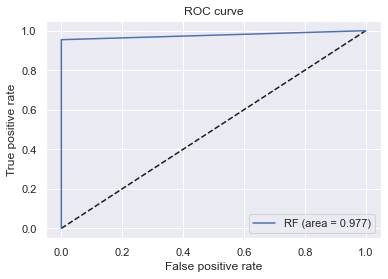

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_rf = prediction_RF
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("Rfroc.jpg")
plt.show()

<AxesSubplot:>

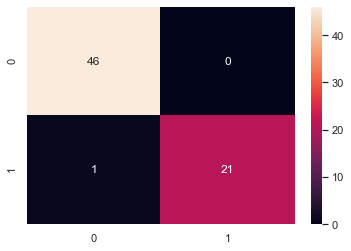

In [25]:
cm = confusion_matrix(y_test, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

In [26]:
import joblib
joblib.dump(RF_model , "my_random_forest.joblib")

['my_random_forest.joblib']

In [50]:
model_json = future_extractor.to_json()
with open("future_extractor.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
future_extractor.save_weights("future_extractor.h5")
print("Saved model to disk")

Saved model to disk
